In [20]:
import tensorflow as tf
from tensorflow.keras import layers, models, applications, regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import os

In [21]:
tf.random.set_seed(42)

In [22]:
base_dir = 'D:/Pneumonia_Project/chest_xray'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')
val_dir = os.path.join(base_dir, 'val')

In [23]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.25,
    zoom_range=0.25,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
train_generator = train_datagen.flow_from_directory(
    train_dir, target_size=(224, 224), batch_size=32, class_mode='binary', color_mode='rgb')

val_generator = val_test_datagen.flow_from_directory(
    val_dir, target_size=(224, 224), batch_size=16, class_mode='binary', color_mode='rgb', shuffle=False)

test_generator = val_test_datagen.flow_from_directory(
    test_dir, target_size=(224, 224), batch_size=16, class_mode='binary', color_mode='rgb', shuffle=False)

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [25]:
normal_count = len(os.listdir(os.path.join(train_dir, 'NORMAL')))
pneumonia_count = len(os.listdir(os.path.join(train_dir, 'PNEUMONIA')))
total = normal_count + pneumonia_count

class_weights = {0: total / (2 * normal_count), 1: total / (2 * pneumonia_count)}

In [26]:
base_model = applications.Xception(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model initially

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

In [27]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ xception (Functional)           │ (None, 7, 7, 2048)     │    20,861,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,387,305 (81.59 MB)

 Trainable params: 525,313 (2.00 MB)

 Non-trainable params: 20,861,992 (79.58 MB)

In [28]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [29]:
# Define a callback to save the best model
model_checkpoint = ModelCheckpoint(
    'xray_best_model.h5',  # Filename
    monitor='val_loss',  # Metric to monitor
    save_best_only=True,  # Save only the best model
    mode='min',  # Mode for metric
    verbose=1  # Print messages
)

# Include the callback in the training process
callbacks = [
    EarlyStopping(patience=7, restore_best_weights=True),
    model_checkpoint,  # Save the best model
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]


In [30]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=10,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=callbacks
)


C:\Users\richa\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7629 - loss: 0.8887 - precision_1: 0.9498 - recall_1: 0.7163
Epoch 1: val_loss improved from inf to 1.12223, saving model to xray_best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 481s 3s/step - accuracy: 0.7632 - loss: 0.8882 - precision_1: 0.9500 - recall_1: 0.7166 - val_accuracy: 0.6875 - val_loss: 1.1222 - val_precision_1: 1.0000 - val_recall_1: 0.3750 - learning_rate: 1.0000e-04
Epoch 2/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8563 - loss: 0.7195 - precision_1: 0.9780 - recall_1: 0.8245
Epoch 2: val_loss improved from 1.12223 to 0.97645, saving model to xray_best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 424s 3s/step - accuracy: 0.8563 - loss: 0.7194 - precision_1: 0.9780 - recall_1: 0.8246 - val_accuracy: 0.8125 - val_loss: 0.9764 - val_precision_1: 1.0000 - val_recall_1: 0.6250 - learning_rate: 1.0000e-04
Epoch 3/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8842 - loss: 0.6622 - precision_1: 0.9822 - recall_1: 0.8611
Epoch 3: val_loss improved from 0.97645 to 0.75362, saving model to xray_best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 434s 3s/step - accuracy: 0.8842 - loss: 0.6621 - precision_1: 0.9822 - recall_1: 0.8612 - val_accuracy: 0.8125 - val_loss: 0.7536 - val_precision_1: 1.0000 - val_recall_1: 0.6250 - learning_rate: 1.0000e-04
Epoch 4/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8948 - loss: 0.6309 - precision_1: 0.9734 - recall_1: 0.8822
Epoch 4: val_loss did not improve from 0.75362
164/164 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.8948 - loss: 0.6308 - precision_1: 0.9735 - recall_1: 0.8822 - val_accuracy: 0.8125 - val_loss: 0.8513 - val_precision_1: 1.0000 - val_recall_1: 0.6250 - learning_rate: 1.0000e-04
Epoch 5/10
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8984 - loss: 0.5901 - precision_1: 0.9791 - recall_1: 0.8827
Epoch 5: val_loss did not improve from 0.75362
164/164 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.8984 - loss: 0.5901 - precision_1: 0.9791 - recall_1: 0.8827 - val_accuracy: 0.8125 - val_loss: 0.8698 - val_precision_1: 1.00

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:100]:
    layer.trainable = False

In [32]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)


In [33]:
history_fine = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=20,
    validation_data=val_generator,
    validation_steps=len(val_generator),
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 28s/step - accuracy: 0.8581 - loss: 0.6829 - precision_2: 0.9677 - recall_2: 0.8339 
Epoch 1: val_loss did not improve from 0.75362
164/164 ━━━━━━━━━━━━━━━━━━━━ 4520s 28s/step - accuracy: 0.8581 - loss: 0.6828 - precision_2: 0.9678 - recall_2: 0.8339 - val_accuracy: 0.7500 - val_loss: 1.2570 - val_precision_2: 1.0000 - val_recall_2: 0.5000 - learning_rate: 1.0000e-05
Epoch 2/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8981 - loss: 0.6034 - precision_2: 0.9834 - recall_2: 0.8780
Epoch 2: val_loss did not improve from 0.75362
164/164 ━━━━━━━━━━━━━━━━━━━━ 1109s 7s/step - accuracy: 0.8981 - loss: 0.6035 - precision_2: 0.9834 - recall_2: 0.8780 - val_accuracy: 0.7500 - val_loss: 1.2780 - val_precision_2: 1.0000 - val_recall_2: 0.5000 - learning_rate: 1.0000e-05
Epoch 3/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9108 - loss: 0.5782 - precision_2: 0.9872 - recall_2: 0.8913
Epoch 3: val_loss did not improve from 0.75362
164/

164/164 ━━━━━━━━━━━━━━━━━━━━ 1163s 7s/step - accuracy: 0.9390 - loss: 0.5328 - precision_2: 0.9827 - recall_2: 0.9342 - val_accuracy: 0.8125 - val_loss: 0.6932 - val_precision_2: 1.0000 - val_recall_2: 0.6250 - learning_rate: 1.0000e-05
Epoch 8/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9449 - loss: 0.5030 - precision_2: 0.9905 - recall_2: 0.9352
Epoch 8: val_loss did not improve from 0.69325
164/164 ━━━━━━━━━━━━━━━━━━━━ 1043s 6s/step - accuracy: 0.9449 - loss: 0.5030 - precision_2: 0.9904 - recall_2: 0.9352 - val_accuracy: 0.8125 - val_loss: 0.7063 - val_precision_2: 1.0000 - val_recall_2: 0.6250 - learning_rate: 1.0000e-05
Epoch 9/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9440 - loss: 0.5179 - precision_2: 0.9847 - recall_2: 0.9391
Epoch 9: val_loss improved from 0.69325 to 0.56864, saving model to xray_best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 1043s 6s/step - accuracy: 0.9440 - loss: 0.5179 - precision_2: 0.9847 - recall_2: 0.9391 - val_accuracy: 0.8750 - val_loss: 0.5686 - val_precision_2: 1.0000 - val_recall_2: 0.7500 - learning_rate: 1.0000e-05
Epoch 10/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9464 - loss: 0.5004 - precision_2: 0.9885 - recall_2: 0.9394
Epoch 10: val_loss did not improve from 0.56864
164/164 ━━━━━━━━━━━━━━━━━━━━ 1018s 6s/step - accuracy: 0.9464 - loss: 0.5004 - precision_2: 0.9885 - recall_2: 0.9394 - val_accuracy: 0.8750 - val_loss: 0.6208 - val_precision_2: 1.0000 - val_recall_2: 0.7500 - learning_rate: 1.0000e-05
Epoch 11/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9470 - loss: 0.5094 - precision_2: 0.9867 - recall_2: 0.9416
Epoch 11: val_loss did not improve from 0.56864
164/164 ━━━━━━━━━━━━━━━━━━━━ 777s 5s/step - accuracy: 0.9470 - loss: 0.5094 - precision_2: 0.9867 - recall_2: 0.9416 - val_accuracy: 0.8750 - val_loss: 0.5688 - val_precision_2

164/164 ━━━━━━━━━━━━━━━━━━━━ 804s 5s/step - accuracy: 0.9600 - loss: 0.4754 - precision_2: 0.9929 - recall_2: 0.9532 - val_accuracy: 0.9375 - val_loss: 0.5452 - val_precision_2: 1.0000 - val_recall_2: 0.8750 - learning_rate: 2.0000e-06
Epoch 14/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9584 - loss: 0.4736 - precision_2: 0.9910 - recall_2: 0.9525
Epoch 14: val_loss improved from 0.54523 to 0.52954, saving model to xray_best_model.h5


164/164 ━━━━━━━━━━━━━━━━━━━━ 642s 4s/step - accuracy: 0.9584 - loss: 0.4736 - precision_2: 0.9910 - recall_2: 0.9525 - val_accuracy: 0.9375 - val_loss: 0.5295 - val_precision_2: 1.0000 - val_recall_2: 0.8750 - learning_rate: 2.0000e-06
Epoch 15/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9561 - loss: 0.4800 - precision_2: 0.9901 - recall_2: 0.9502
Epoch 15: val_loss did not improve from 0.52954
164/164 ━━━━━━━━━━━━━━━━━━━━ 670s 4s/step - accuracy: 0.9561 - loss: 0.4800 - precision_2: 0.9901 - recall_2: 0.9502 - val_accuracy: 0.9375 - val_loss: 0.5491 - val_precision_2: 1.0000 - val_recall_2: 0.8750 - learning_rate: 2.0000e-06
Epoch 16/20
164/164 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9505 - loss: 0.4923 - precision_2: 0.9881 - recall_2: 0.9451
Epoch 16: val_loss did not improve from 0.52954
164/164 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - accuracy: 0.9505 - loss: 0.4922 - precision_2: 0.9881 - recall_2: 0.9451 - val_accuracy: 0.9375 - val_loss: 0.5794 - val_precision_2: 

In [34]:
test_results = model.evaluate(test_generator)
print(f'Test Accuracy: {test_results[1]:.2%}')
print(f'Test Precision: {test_results[2]:.2%}')
print(f'Test Recall: {test_results[3]:.2%}')

39/39 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step - accuracy: 0.9239 - loss: 0.6015 - precision_2: 0.5404 - recall_2: 0.6083
Test Accuracy: 92.31%
Test Precision: 94.30%
Test Recall: 93.33%


In [35]:
y_pred = model.predict(test_generator) > 0.5
y_true = test_generator.classes

39/39 ━━━━━━━━━━━━━━━━━━━━ 57s 1s/step


              precision    recall  f1-score   support

           0       0.89      0.91      0.90       234
           1       0.94      0.93      0.94       390

    accuracy                           0.92       624
   macro avg       0.92      0.92      0.92       624
weighted avg       0.92      0.92      0.92       624



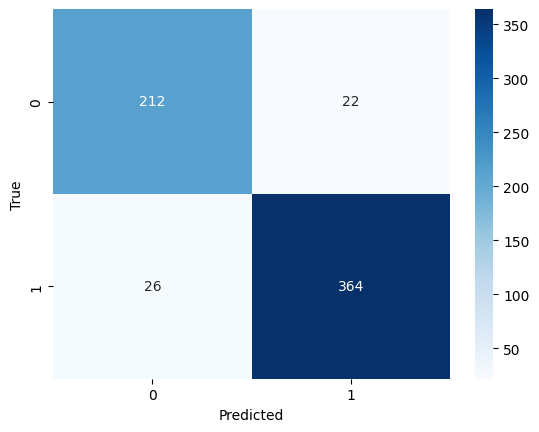

In [36]:
print(classification_report(y_true, y_pred))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [37]:

# Modified Grad-CAM function
def grad_cam(model, img_array, layer_name, eps=1e-8):
    # Extract the base model (assuming it's the first layer)
    base_model = model.layers[0] if isinstance(model.layers[0], tf.keras.Model) else model
    
    # Create a model that maps input image to activations and output
    grad_model = tf.keras.models.Model(
        inputs=base_model.input, 
        outputs=[base_model.get_layer(layer_name).output, base_model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0]  # Assuming binary classification

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + eps)
    
    return heatmap.numpy()


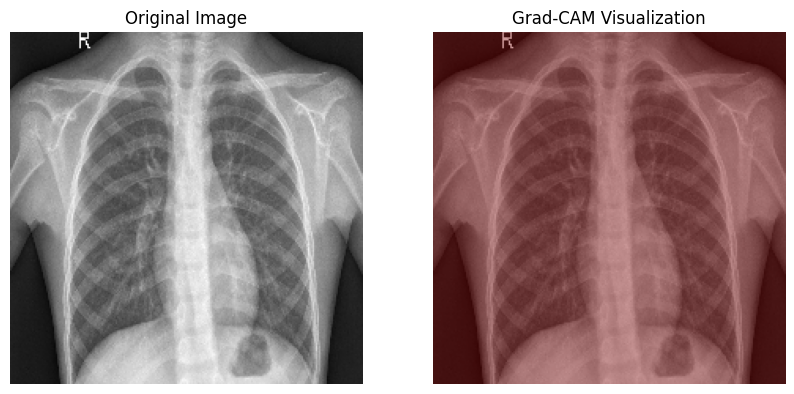

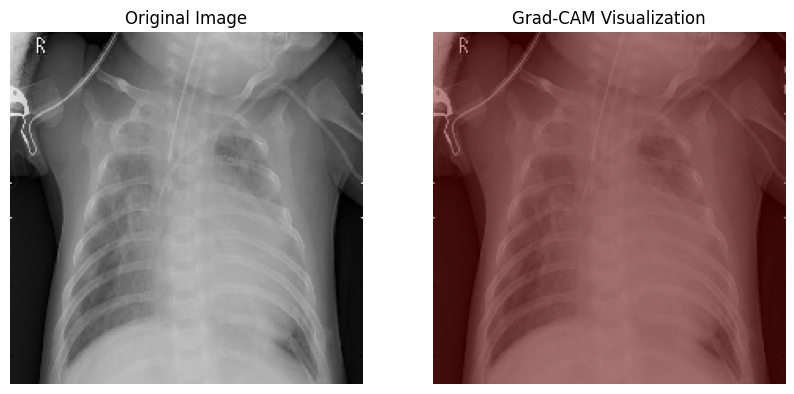

In [39]:
# Updated visualization function
def visualize_gradcam(img_path, model, layer_name='block14_sepconv2'):
    # Load and preprocess image
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=(224, 224))
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0
    
    # Get Grad-CAM heatmap
    heatmap = grad_cam(model, img_array, layer_name)
    
    # Resize heatmap to match original image size
    heatmap = cv2.resize(heatmap, (img.width, img.height))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Superimpose heatmap on original image
    superimposed_img = cv2.addWeighted(cv2.cvtColor(np.array(img), cv2.COLOR_RGB2BGR), 0.6, heatmap, 0.4, 0)
    
    # Plot images
    plt.figure(figsize=(10, 5))
    plt.subplot(121)
    plt.imshow(img)
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(122)
    plt.imshow(superimposed_img)
    plt.title('Grad-CAM Visualization')
    plt.axis('off')
    plt.show()
    
# Print available convolutional layers in the base model
def print_conv_layers(model):
    base_model = model.layers[0] if isinstance(model.layers[0], tf.keras.Model) else model
    print("Available convolutional layers:")
    for layer in base_model.layers:
        if 'conv' in layer.name or 'sepconv' in layer.name:
            print(layer.name)
# Define image paths correctly
sample_normal_img = r"D:\Pneumonia_Project\chest_xray\test\NORMAL\IM-0001-0001.jpeg"
sample_pneumonia_img = r"D:\Pneumonia_Project\chest_xray\test\PNEUMONIA\person1_virus_6.jpeg"

# Now, call the function
visualize_gradcam(sample_normal_img, model, 'block14_sepconv2')
visualize_gradcam(sample_pneumonia_img, model, 'block14_sepconv2')
